# W2D1 Tutorial 3: Extreme value analysis - the GEV distribution

#### __Week 2, Day 4, Extremes & Vulnerability__
##### __Content creators:__ Matthias Aengenheyster, Joeri Reinders
##### __Content reviewers:__ TBD
##### __Content editors:__ TBD
##### __Production editors:__ TBD
##### __Our 2023 Sponsors:__ TBD

## Tutorial Objectives:

In the previous tutorial we computed "empirical return levels". The second method to determine return values is by computing the probability of exceedence from a probability
density function that has been fitted to the data. For example the normal distribution pdf that we created in
tutorial 1. However we noticed that the normal distribution did not fit well to our precipitation data.

By the end of the tutorial you will be able to:
- Create the Quantile plot to assess how well a distribution fits the data
- Fit a GEV distribution to the data
- Understand how the parameters of the GEV distribution control its behavior.

## Setup

In [ ]:
# Installs

In [ ]:
#install dependencies - taken from <Yosmely Bermúdez> comments for Tutorial 6
# We need this to install eigen which is needed for SDFC to install correctly
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda install eigen
# !pip install -v https://github.com/yrobink/SDFC/archive/master.zip#subdirectory=python
# !pip install https://github.com/njleach/mystatsfunctions/archive/master.zip
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install cartopy
# !pip install scipy
# !pip install texttable

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import cartopy.crs as ccrs
from scipy import stats

In [2]:
import extremes_functions as ef
from mystatsfunctions import OLSE, LMoments
import SDFC as sd

Lets repeat our first steps from tutorials 1 and 2: 
1) open the precipitation annual block maxima record, 
2) create a histogram of the data and plot the a normal distribution probability density function.

In [3]:
import os, pooch

fname = 'precipitationGermany_1920-2022.csv'
if not os.path.exists(fname):
    url = "https://osf.io/xs7h6/download"
    fname = pooch.retrieve(url, known_hash=None)

data = pd.read_csv(fname, index_col=0).set_index('years')
data.columns=['precipitation']
precipitation = data.precipitation

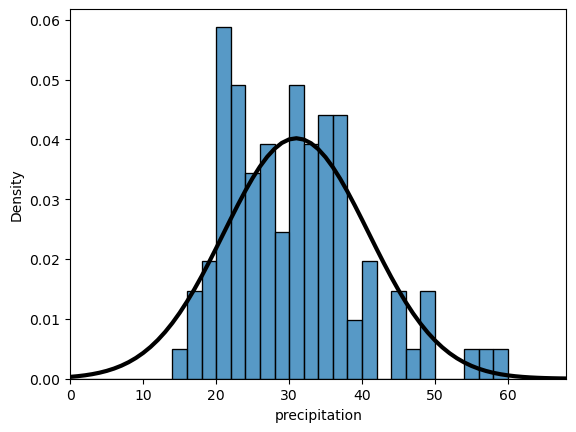

In [4]:
bins=np.arange(0,precipitation.max(),2)
sns.histplot(precipitation,bins=bins,stat='density')
plt.xlim(bins[0],bins[-1])

ylim = plt.ylim()

x = np.arange(0,100,1)
plt.plot(x,stats.norm.pdf(x,precipitation.mean(),precipitation.std()),c='k',lw=3)

Next we create a Quantile plots (QQ plot) from where we judge the fit of the our data to a normal distribution. Recall from the lecture that a QQ plot plots the *actual* percentiles of the data against the *expected* percentiles assuming the distribution is e.g. a normal distribution.

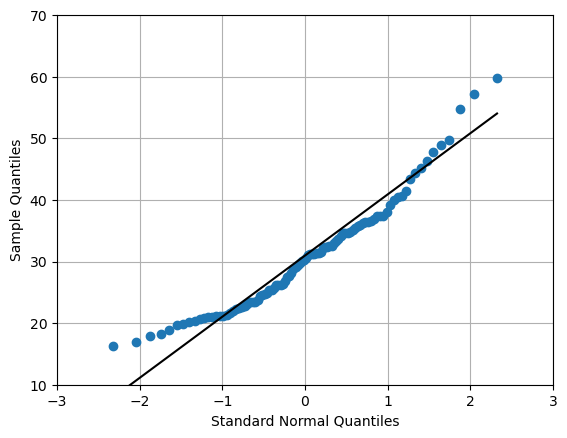

In [5]:
x = np.linspace(0,1,100)

plt.plot(stats.norm.ppf(x),np.quantile(precipitation,x),'o')
plt.plot(stats.norm.ppf(x),stats.norm.ppf(x,precipitation.mean(), precipitation.std()),'k-')

plt.xlim(-3,3)
plt.ylim(10,70)

plt.xlabel('Standard Normal Quantiles')
plt.ylabel('Sample Quantiles')

plt.grid(True)

Hopefully you agree with me that the fit can be better. Especially the extreme values seem to be under- 
and overestimated by the normal distribution model.So let’s try something new... because there are many other 
distributions. For example the General Extreme Value distribution.

The GEV distribution has three parameters that define its shape: the location, scale and shape parameter. 
Just to give you some context, the normal distribution only has two parameters: the mean and the standard 
deviation. If you increase the mean the distribution will shift to higher values, and if you increase the 
standard deviation the distribution will become wider. The normal distribution therefore is symmetrical as 
there is no parameter that affects its skew – this often makes the normal distribution problematic to use. 

In the GEV distribution the location and scale parameter behave similar to the mean and standard deviation
in the normal distribution. The shape-parameter affects the tails of the distribution by making them thinner 
or thicker. Extreme event distributions often have thick tails meaning that they are slightly skewed. Adjusting
the shape-parameter, thus affects the skew (and kurtosis) of your data.

To fit the parameters of the GEV distribution we use the SDFC package. The normal distribution has the parameters mean and standard deviation. In contrast, the the GEV 
distribution has three parameters (location,scale,shape) – these also depend on each other so they cannot be estimated individually.
Fitting the parameters to the data is done by the package.

In [6]:
gev = stats.genextreme
gev.fit(precipitation)

(-0.04713627253201371, 26.353589255720397, 7.369426736450237)

In [7]:
fit, model = ef.fit_return_levels_sdfc(precipitation.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=10,full=True,model=True)

In [8]:
fit

<xarray.Dataset>
Dimensions:            (return period: 999, N: 10, return_period_obs: 103)
Coordinates:
  * return period      (return period) float64 1.1 2.1 3.1 ... 997.1 998.1 999.1
  * N                  (N) int64 0 1 2 3 4 5 6 7 8 9
  * return_period_obs  (return_period_obs) float64 1.01 1.02 1.03 ... 52.0 104.0
Data variables:
    return level       (return period, N) float64 20.72 21.1 ... 69.41 133.8
    mu                 (N) float64 27.5 27.37 25.89 26.88 ... 26.99 26.66 25.05
    sigma              (N) float64 7.686 7.014 7.694 6.71 ... 7.339 6.865 7.015
    xi                 (N) float64 -0.01831 -0.05087 0.03399 ... -0.03049 0.2093
    return_level_obs   (return_period_obs) float64 15.6 16.2 16.9 ... 59.9 69.5

In [9]:
model

+-----------+--------+------------+--------+----------------+----------------+
| GEV (mle) |  Link  |    Type    |  coef  | Quantile 0.025 | Quantile 0.975 |
+===========+========+============+========+================+================+
| loc       | IdLink | Stationary | 26.354 | 25.201         | 27.468         |
+-----------+--------+------------+--------+----------------+----------------+
| scale     | IdLink | Stationary | 7.369  | 6.745          | 7.692          |
+-----------+--------+------------+--------+----------------+----------------+
| shape     | IdLink | Stationary | 0.047  | -0.073         | 0.198          |
+-----------+--------+------------+--------+----------------+----------------+

(20.0, 110.0)

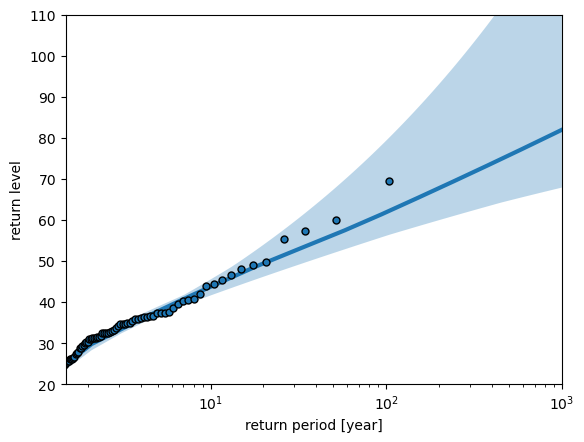

In [10]:
ef.plot_levels_from_obj(fit,alpha=1)
plt.xlim(1.5,1000)
plt.ylim(20,110)

(10.0, 72.0)

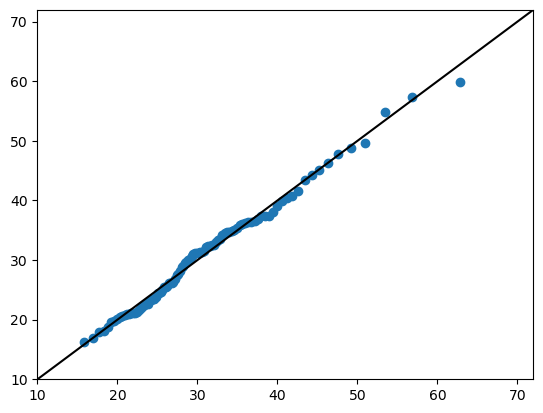

In [11]:
x = np.linspace(0,1,100)

plt.plot(gev.ppf(x, -fit.xi.mean().values, loc=fit.mu.mean().values, scale=fit.sigma.mean().values), np.quantile(precipitation,x),'o')

plt.plot([0,100],[0,100],'k')

plt.xlim(10,72)
plt.ylim(10,72)

Now create a plot with two panels each one showing a QQplot (one of the normal distribution fit, one of the GEV 
distribution fit). Similarly create a plot with two panels that show the histogram and pdf (again one with the normal 
distribution pdf and one with the GEV distribution pdf). 

Finally, try to plot both pdf's (normal and GEV) over eachother so you can see the differences between them.

In [12]:
precipitation

years
1920    24.5
1921    27.7
1922    15.6
1923    23.5
1924    59.9
        ... 
2018    31.6
2019    24.9
2020    33.3
2021    57.4
2022    25.4
Name: precipitation, Length: 103, dtype: float64

<AxesSubplot:xlabel='precipitation', ylabel='Density'>

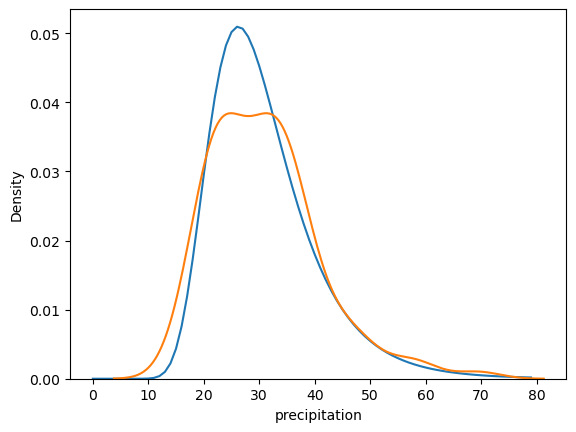

In [13]:
x = np.arange(80)
plt.plot(x,gev.pdf(x, -fit.xi.mean().values, loc=fit.mu.mean().values, scale=fit.sigma.mean().values))
sns.kdeplot(precipitation)

Text(0.5, 1.0, 'GEV distribution fit')

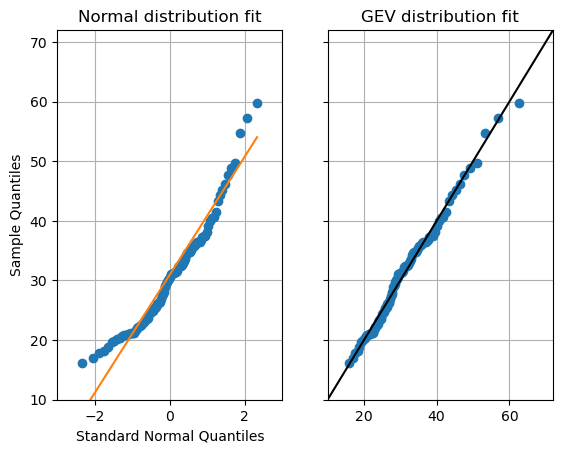

In [14]:
fig, ax = plt.subplots(1,2,sharey=True)

plt.sca(ax[0])

x = np.linspace(0,1,100)

plt.plot(stats.norm.ppf(x),np.quantile(precipitation,x),'o')
plt.plot(stats.norm.ppf(x),stats.norm.ppf(x,precipitation.mean(), precipitation.std()),'-')

plt.xlim(-3,3)
plt.ylim(10,70)

plt.xlabel('Standard Normal Quantiles')
plt.ylabel('Sample Quantiles')

plt.grid(True)

plt.sca(ax[1])
x = np.linspace(0,1,100)


plt.plot(gev.ppf(x, -fit.xi.mean().values, loc=fit.mu.mean().values, scale=fit.sigma.mean().values), np.quantile(precipitation,x),'o')

plt.plot([0,100],[0,100],'k')

plt.xlim(10,72)
plt.ylim(10,72)

plt.grid(True)


ax[0].set_title('Normal distribution fit')
ax[1].set_title('GEV distribution fit')

Text(0.5, 1.0, 'GEV')

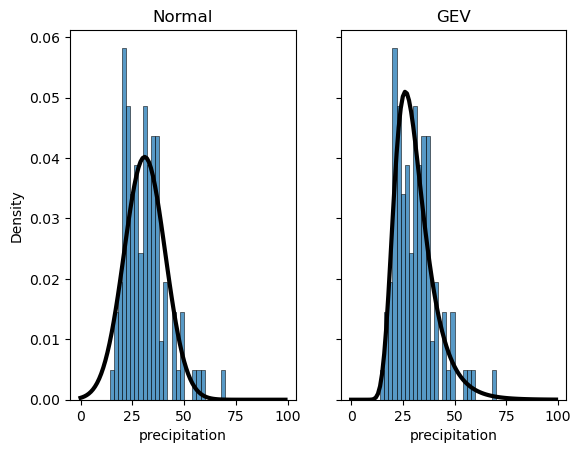

In [15]:
fig, ax = plt.subplots(1,2,sharex=True,sharey=True)
sns.histplot(precipitation,ax=ax[0],bins=np.arange(0,80,2),stat='density')
sns.histplot(precipitation,ax=ax[1],bins=np.arange(0,80,2),stat='density')

x = np.arange(0,100,1)
ax[0].plot(x,stats.norm.pdf(x,precipitation.mean(),precipitation.std()),c='k',lw=3)
ax[1].plot(x,gev.pdf(x, -fit.xi.mean().values, loc=fit.mu.mean().values, scale=fit.sigma.mean().values),c='k',lw=3)


ax[0].set_title('Normal')
ax[1].set_title('GEV')

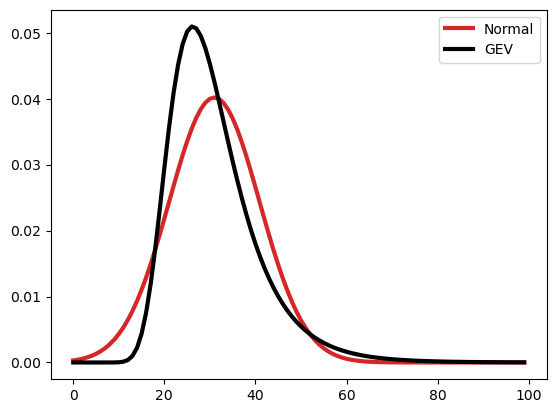

In [16]:
plt.plot(x,stats.norm.pdf(x,precipitation.mean(),precipitation.std()),c='C3',lw=3,label='Normal')
plt.plot(x,gev.pdf(x, -fit.xi.mean().values, loc=fit.mu.mean().values, scale=fit.sigma.mean().values),c='k',lw=3,label='GEV')
plt.legend()

How well do the two fitted distributions reflect the observed data and how do they compare to each other? 

## Coding excercise: Parameters of the GEV distribution

Play a little with the gev.pdf function to get a better sense of how the parameters affect the shape of the pdf (distribution). Plot the distribution against the
‘x’ sequence and randomly change the parameters. What does each parameter do? 

Create three plots. In each, one of the parameters (location, scale, shape) is varied while the other two are held constant. The parameter values and ranges below may be a useful starting point.

In [25]:
loc = 26
scale = 7
shape = 0

range_loc = np.arange(20,40,4)
range_scale = np.arange(4,10,1)
range_shape = np.arange(-0.4,0.4+0.1,0.1)

# useful variable range for the chosen parameters
x = np.linspace(0,80,1000)


### student

In [21]:
...

Ellipsis

### solution

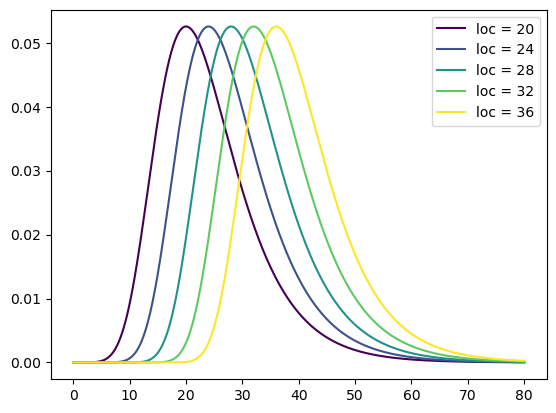

In [22]:
fig, ax = plt.subplots()
x = np.linspace(0,80,1000)
colors = plt.cm.viridis(np.linspace(0,1,range_loc.size))
i = 0
for loci in range_loc:
    p = plt.plot(x,gev.pdf(x, -shape, loc=loci, scale=scale),color=colors[i],label='loc = %i' % loci)
    i += 1
plt.legend()

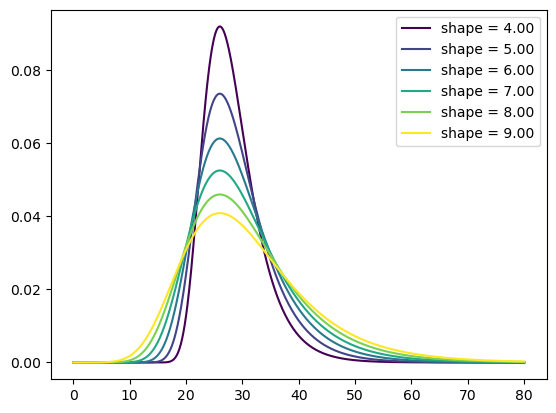

In [23]:
fig, ax = plt.subplots()
x = np.linspace(0,80,1000)
colors = plt.cm.viridis(np.linspace(0,1,range_scale.size))
i = 0
for scalei in range_scale:
    plt.plot(x,gev.pdf(x, -shape, loc=loc, scale=scalei),color=colors[i],label='shape = %.2f' % scalei)
    i += 1
plt.legend()

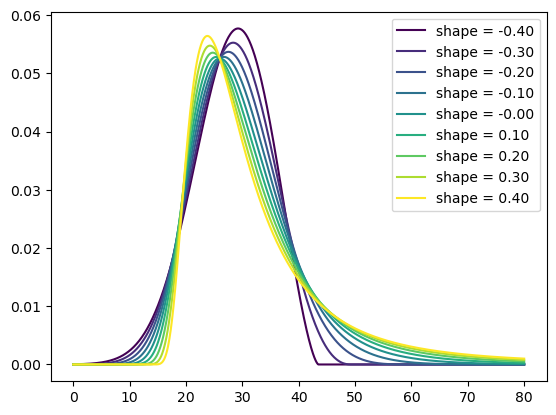

In [24]:
fig, ax = plt.subplots()
x = np.linspace(0,80,1000)
colors=plt.cm.viridis(np.linspace(0,1,range_shape.size))
i = 0
for shapei in range_shape:
    plt.plot(x,gev.pdf(x, -shapei, loc=loc, scale=scale),color=colors[i],label='shape = %.2f' % shapei)
    i += 1
plt.legend()